<a href="https://colab.research.google.com/github/morcellinus/Introduction_to_Deep_Learning/blob/main/LJM_lab09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 9b – Custom Dataset & Transfer Learning

## Part A. MS Cats and Dogs
- Ensure that you **enable GPU** and work on Part A in one go to save time
- Download the zip file from this website to your local machine https://www.microsoft.com/en-us/download/details.aspx?id=54765
- Click on the red "Download" button to download it to your computer.

### Save Zip to Drive and Mount Drive
- Upload the zip file `kagglecatsanddogs_3367a.zip` onto a folder called "DL" in your Drive (might take a few minutes)
- You can name the folder anything you want but replace "DL" with that folder in the code cells below
- You will be asked for an authorisation code. Follow the link, sign in and copy the code
- You should see "gdrive" folder on the left pane



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


### Inspect the folder where the zip file is
- Replace `DL` with your own folder or remove it from that path if it is in your main Drive folder

In [ ]:
!ls '/content/gdrive/MyDrive/DL/'

kagglecatsanddogs_3367a  kagglecatsanddogs_3367a.zip


### Copy it to your current directory
- When this code cell finishes, refresh the folder on the left pane and you should see the zip file in it

In [ ]:
!cp '/content/gdrive/MyDrive/DL/kagglecatsanddogs_3367a.zip' .

### Unzip the zip file
- You should now see `PetImages` folder with `Cat` and `Dog` folders inside
- You may want to close the cell code output after it is done

In [ ]:
!unzip kagglecatsanddogs_3367a.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/5522.jpg  
  inflating: P

In [ ]:
import glob # Unix style pathname pattern matching
import cv2 # OpenCV
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn
import torchvision
from torchvision import models

import torchvision.utils
from torch.utils.data import Dataset, DataLoader

### Pre-processing: Organise Images Contained in Folders
- Normally training and test data are organised in SEPARATE directories so you can easily just call the constructor class on these separate folders
- However, we only have two folders containing **ALL images** of cats and dogs respectively and there are **NO labels** provided. The folder name is the indication of the class label.
- Often you might also work with **annotation files** that give textual references to which might be slightly easier to work with
- Here, we will go through all the image files contained in `PetImages` (and its subdirectories) and for each of them, store their path and class label in a list called **`init_data`**
- We will use *glob* and *OpenCV* to do these
- We will do the data splitting into train set and test set later

In [ ]:
root_dir = "PetImages/"

# Retrieve the list of ALL folders and files inside the base folder
file_list = glob.glob(root_dir + "*") # ['PetImages/Dog', 'PetImages/Cat']

init_data = []
# Create a list that would contain the paths to all the images in the dataset
for class_path in file_list:
    class_name = class_path.split("/")[-1] # extract the class name, e.g. 'PetImages/Dog' --> 'Dog'
    # Retrieve each image in their folders (i.e. 0.jpg, 1.jpg, etc.)
    for img_path in glob.glob(class_path + "/*.jpg"): # for each file with the extension ".jpg"
        # Check for problematic images
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)                 
        if type(img) is np.ndarray:
          if img.size == 0:
            continue
        if img is None:
            continue
        init_data.append([img_path, class_name]) # append image file path to init_data list, and its class name

print(init_data) # [['PetImages/Dog/4.jpg', 'Dog'], ...]  
print(len(init_data))

# Q1. Given that there are a total of 25,000 images in the folders, did all the images get saved into init_data? 
# Explain why do you think not all images were loaded if that was the case.
print('\nWe only got 24946 images saved out of 25000 images, since some files are not with the extension .jpg, or even the extension of a file is .jpg, there might be some files that has 0 length')


[['PetImages/Dog/2042.jpg', 'Dog'], ['PetImages/Dog/5438.jpg', 'Dog'], ['PetImages/Dog/10883.jpg', 'Dog'], ['PetImages/Dog/6378.jpg', 'Dog'], ['PetImages/Dog/12393.jpg', 'Dog'], ['PetImages/Dog/2403.jpg', 'Dog'], ['PetImages/Dog/9247.jpg', 'Dog'], ['PetImages/Dog/1787.jpg', 'Dog'], ['PetImages/Dog/1170.jpg', 'Dog'], ['PetImages/Dog/4322.jpg', 'Dog'], ['PetImages/Dog/6318.jpg', 'Dog'], ['PetImages/Dog/9839.jpg', 'Dog'], ['PetImages/Dog/7563.jpg', 'Dog'], ['PetImages/Dog/7905.jpg', 'Dog'], ['PetImages/Dog/7039.jpg', 'Dog'], ['PetImages/Dog/7584.jpg', 'Dog'], ['PetImages/Dog/3043.jpg', 'Dog'], ['PetImages/Dog/3513.jpg', 'Dog'], ['PetImages/Dog/8866.jpg', 'Dog'], ['PetImages/Dog/4311.jpg', 'Dog'], ['PetImages/Dog/1060.jpg', 'Dog'], ['PetImages/Dog/10708.jpg', 'Dog'], ['PetImages/Dog/4700.jpg', 'Dog'], ['PetImages/Dog/10670.jpg', 'Dog'], ['PetImages/Dog/2732.jpg', 'Dog'], ['PetImages/Dog/9720.jpg', 'Dog'], ['PetImages/Dog/10241.jpg', 'Dog'], ['PetImages/Dog/6554.jpg', 'Dog'], ['PetImages/Do

### Display any one image

(403, 500)

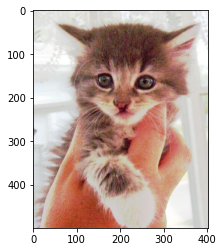

In [ ]:
# Display any image with known name
from PIL import Image

img = Image.open('PetImages/Cat/100.jpg')
plt.imshow(img)  
img.size

### Device Configuration and Hyper-parameters

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Hyper-parameters
SIZE = 224
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)
BATCH = 4
EPOCHS = 1
LR = 0.001

cuda


### Create a Custom Dataset
- This class contains three main methods `__init__()`, `__len__()` and `__getitem__()`
- All three should be implemented although `__init__()` is not mandatory

In [ ]:
class CustomCatDog(Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        # Dictionary containing mapping between string and number (class label)
        self.class_map = {"Dog" : 0, "Cat": 1} 
        # Set image dimensions
        self.img_dim = (SIZE, SIZE) 
        # Perform any transformations
        self.transform = transform

    def __len__(self):
        return len(self.data)

    # This function is called when an element of this class is accessed via dataset[index]
    def __getitem__(self, index):
        # Get image path and class name
        img_path, class_name = self.data[index] # tuple from __init__()
        # Obtain the image from its path and resize it to the required dimension
        img = cv2.imread(img_path, cv2.IMREAD_COLOR) 
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name] # get the class label, e.g. 0 (for "Dog")
        pil_img=Image.fromarray(img) # convert ndarray to PIL
        # Perform transforms if there are any
        if self.transform:
            img_tensor = self.transform(pil_img)
        # Convert class label to a tensor
        class_id = torch.tensor(class_id) 

        return img_tensor, class_id


### Transforms
- Training set and test set have slightly different transforms

In [ ]:
import torchvision.transforms as transforms

train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(SIZE, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD)
    ])

test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD)
    ])

# Q2. Why is resizing not done in transforms?
print('Because resizing is already defined in CustomcatDog class')

# Q3. Think of ONE more transform that could be applied on the train set. You DO NOT have to implement it.
print('\nWe can try shearing of the image to get various color combinations of the image.')

Because resizing is already defined in CustomcatDog class

We can try shearing of the image to get various color combinations of the image.


### Split Dataset into Training & Test Sets and Load

In [ ]:
# Divide dataset into training and test sets using 80/20 ratio
train_size = int(0.8 * len(init_data))
test_size = len(init_data) - train_size
train_set, test_set = torch.utils.data.random_split(init_data, [train_size, test_size])

trainset = CustomCatDog(train_set, transform=train_transforms)

testset = CustomCatDog(test_set, transform=test_transforms)

train_loader = DataLoader(trainset, batch_size=BATCH,
                          shuffle=True, num_workers=2, pin_memory=True)

test_loader = DataLoader(testset, batch_size=BATCH,
                          shuffle=False, num_workers=2, pin_memory=True)


# Q4. What is the effect of splitting the data randomly and shuffling the data when loading?
print('Random split will provide unbiased train and test set than when it is splitted by its sequence. Also, the batches will be made up from different samples through shuffling, which can help increase model performance by finding a good direction.')

Random split will provide unbiased train and test set than when it is splitted by its sequence. Also, the batches will be made up from different samples through shuffling, which can help increase model performance by finding a good direction.


### Visualisation

torch.Size([4, 3, 224, 224])

class labels: tensor([0, 1, 0, 0])

For channel 1, mean value is 0.4914 and std value is 0.2023. 
For the second channel, 0.4822 for mean value and 0.1994 for std value. 
For the last channel, mean value is 0.4465 and std value is 0.2010

These images are stored in the grid with 4 rows.



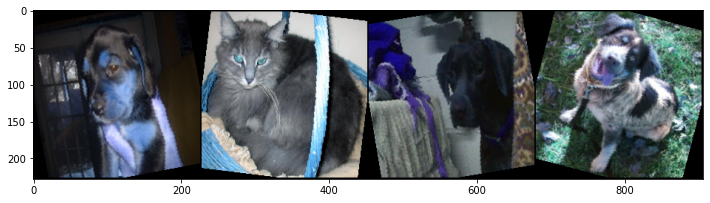

In [ ]:
# A function to denormalise an image for better visualisation
def inverse_normalize(tensor, mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)):
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device)
    std = torch.as_tensor(std, dtype=tensor.dtype, device=tensor.device)
    if mean.ndim == 1:
        mean = mean.view(-1, 1, 1)
    if std.ndim == 1:
        std = std.view(-1, 1, 1)
    tensor.mul_(std).add_(mean)
    return tensor

# Get a batch of images from the train loader
batch = next(iter(train_loader))

images, labels = batch

print(images.shape)

images = inverse_normalize(tensor=images, mean=MEAN, std=STD)  

# Create a grid 
plt.figure(figsize=(12,12))
grid = torchvision.utils.make_grid(tensor=images, nrow=4) # nrow = number of images displayed in each row

print(f"\nclass labels: {labels}")

# Use grid.permute() to transpose the grid so that the axes meet the specifications required by 
# plt.imshow(), which are [height, width, channels]. PyTorch dimensions are [channels, height, width].
plt.imshow(grid.permute(1,2,0))

# Q5. What are the values passed into inverse_normalize() for mean and std in this code cell?
print('\nFor channel 1, mean value is 0.4914 and std value is 0.2023. \nFor the second channel, 0.4822 for mean value and 0.1994 for std value. \nFor the last channel, mean value is 0.4465 and std value is 0.2010')
# Q6. Where are these displayed images stored?
print('\nThese images are stored in the grid with 4 rows.\n')

### Load a Pre-trained Model

In [ ]:
from torchvision import models

# VGG16 Model Loading
use_pretrained = True
model = models.vgg16(pretrained=use_pretrained)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Q7. Why does the final output layer of VGG16 contain 1000 units?

print('This is because the original model is for the classification of 1,000 labels data')

This is because the original model is for the classification of 1,000 labels data


### Get final layer name

In [ ]:
# Run this code cell to see all the names of the layers
for n, m in model.named_modules():
     m.auto_name = n
     print(n)


features
features.0
features.1
features.2
features.3
features.4
features.5
features.6
features.7
features.8
features.9
features.10
features.11
features.12
features.13
features.14
features.15
features.16
features.17
features.18
features.19
features.20
features.21
features.22
features.23
features.24
features.25
features.26
features.27
features.28
features.29
features.30
avgpool
classifier
classifier.0
classifier.1
classifier.2
classifier.3
classifier.4
classifier.5
classifier.6


### Make modifications to the Final Output Layer Only

In [ ]:
# Change the Last Layer, classifier[6]
# Output Features 1000 -> 2
model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)
print('Done')

# Q8. Why are there 2 units in the final output layer now? What type of task is the network trying to learn?
print('The final output layer only has 2 units since our task is binary classification between cat and dog')

Done
The final output layer only has 2 units since our task is binary classification between cat and dog


### Specify Layers for Parameter Updates

In [ ]:
# Create list
params_to_update = []

update_params_name = ['classifier.6.weight', 'classifier.6.bias']

for name, param in model.named_parameters():
    if name in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False


classifier.6.weight
classifier.6.bias


In [ ]:
# Q9. How many layers will be retrained according to the code?
print('Only one layer will be retained')
# Q10. Which layers will be retrained?
print('\nThe one layer will be the final fully connected layer')

Only one layer will be retained

The one layer will be the final fully connected layer


### Loss and Optimiser

In [ ]:
import torch.nn as nn
import torch.optim as optim

# Important! Place model on GPU BEFORE optimiser is initialised
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=params_to_update, lr=0.0005)

# Q11. Looking at the loss function, what output activation function will this neural network have?
print('CrossEntropyLoss has sigmoid output activation function')
# Q12. Why is the first argument to the optimiser not model.parameters()?
print('\nThis is because we only use parameters(weights) for the last layer of the pretrained set, which we redefined suitable for our data. ')

CrossEntropyLoss has sigmoid output activation function

This is because we only use parameters(weights) for the last layer of the pretrained set, which we redefined suitable for our data. 


### Training Loop
- Function `train()` takes in the NN model, `net`, the training data loader, `dataloader`, the test_loader, `val_dataloader`, optimiser and loss


In [ ]:
import time

n_total_steps = len(train_set)
n_iterations = -(-n_total_steps // BATCH) # ceiling division
print(f'Total steps: {n_total_steps}')
print(f'Iterations per epoch: {n_iterations}')

def test(net, dataloader):
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            acc = 100 * correct / total
    print(f'Val Accuracy: {acc:.2f}')
    net.train()
    return round(acc, 2)

def train(net, dataloader, test_dataloader, optimizer, criterion):
    since = time.time() # start time

    num_epochs = 1
    net.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            freq = 50
            if ((i+1) % freq) == 0:
                print(f'Epoch {epoch + 1} Iteration {i + 1}/{n_iterations} Train Loss: {(running_loss / freq):.4f}')
                running_acc = test(net, test_dataloader)
                if (running_acc >= 97.75): # stop when 97.75% accuracy is reached
                  break
                running_loss = 0.0

    time_elapsed = time.time() - since
    print(f'Finished Training {time_elapsed}')

Total steps: 19956
Iterations per epoch: 4989


### Call the Train Function

In [ ]:
train(model, train_loader, test_loader, optimizer, criterion)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1 Iteration 50/4989 Train Loss: 0.3938
Val Accuracy: 96.75
Epoch 1 Iteration 100/4989 Train Loss: 0.1430
Val Accuracy: 97.03
Epoch 1 Iteration 150/4989 Train Loss: 0.0934
Val Accuracy: 97.33
Epoch 1 Iteration 200/4989 Train Loss: 0.1109
Val Accuracy: 97.45
Epoch 1 Iteration 250/4989 Train Loss: 0.1359
Val Accuracy: 97.88
Finished Training 630.7789607048035


In [ ]:
# Q13. What was the accuracy on the test set after the first 50 iterations?
print('The accuracy on the test set after the first 50 iterations was 0.3938')
# Q14. What explains the high accuracy after just the first 50 iterations?
print('\nThe high accuracy after just the first 50 iterations could be attained since we are using pre-trained model(which is verl very well trained and proved with high accuracy')
# Q15. Why is training still relatively slow using a small batch size of 4?
print('\nThe training is relatively slow sinve we used very small value of learning rate for the training.')

The accuracy on the test set after the first 50 iterations was 0.3938

The high accuracy after just the first 50 iterations could be attained since we are using pre-trained model(which is verl very well trained and proved with high accuracy

The training is relatively slow sinve we used very small value of learning rate for the training.


### Exercise: Use Any Other Pre-trained Model
- Try to load a different pre-trained model and modify just the final output layer to be retrained with the cats and dogs custom dataset
- A list of all available models is here https://pytorch.org/vision/stable/models.html
- Try one of these: `resnet18, inception, squeezenet, googlenet` or any other model of your choice


### Part B. Bees and Ants (ImageFolder)
- Simple illustration of using ImageFolder for loading images

In [ ]:
import torch
import torchvision.transforms as transforms

import os


In [ ]:
# Q16. Download the zip file from here https://download.pytorch.org/tutorial/hymenoptera_data.zip


## Unzip the file

In [ ]:
# Q17. Unzip the file
!cp '/content/gdrive/MyDrive/DL/hymenoptera_data.zip' .
!unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

In [ ]:
# Inspect the folder where the files are unzipped to and answer the following questions

# Q18. What is the name of the main (root) directory of this dataset?
print('The root directory of this dataset is [hymenoptera_data]')
# Q19. Is this data already organised into training and validation sets?
print('\nThe dataset is already splitted into train and valid set, distinguished by its sub directory [train] or [val]')
# Q20. What are the number of classes in this dataset and the class names?
print('\nThere are only two calsses: Bees and Ants. Therefore this will be binary classification task.')

In [ ]:
# Q21. Set the data directory to the root directory
data_dir = "hymenoptera_data/"

# Q22. Set the number of classes
num_classes = 2

### Use ImageFolder and DataLoader
- When the data is already organised into train and test sets, `torchvision.datasets.ImageFolder` class can be used to directly store the data and also perform transforms.

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import os
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


image_datasets = {x: ImageFolder(os.path.join(data_dir, x),
                                 data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x], 
                             batch_size=4,
                             shuffle=True)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Visualise the Images

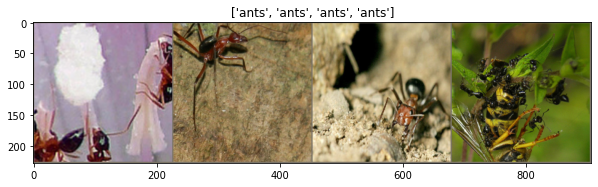

In [ ]:
inputs, labels = next(iter(dataloaders['train']))
grid_images = torchvision.utils.make_grid(inputs)

def no_normalize(im):
    im = im.permute(1, 2, 0)
    im = im*torch.Tensor([0.229, 0.224, 0.225])+torch.Tensor([0.485, 0.456, 0.406])
    return im


grid_images = no_normalize(grid_images)
plt.figure(figsize = (10,10))
plt.title([class_names[x] for x in labels])
plt.imshow(grid_images)

plt.show()